# NLP and ML algorithms to analyze gender bias in cultural journalism
#### The following notebook presents a number of Python-based NLP and ML algorithms and techniques that were used to analyze a set of articles collected from the New York Times. We investigate gender bias in cultural journalism by utilizing word embeddings and classification algorithms. Along the notebook, we will save and re-load the dataset several times to save changes applied to the data (such savings can be interpreted as 'checkpoints' given that the analysis required an extended period of time).

**Important note**: some plots were removed from the output of this notebook as they have been already included in the final report.

## Importing all necessary packages
Import all necessary packages to perform analysis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from numpy.linalg import norm
from itertools import chain
from tabulate import tabulate
import ast
from random import shuffle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

import imblearn
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, mean_squared_error, accuracy_score, classification_report
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
!pip install shap
import shap

from scipy.spatial import distance
import scipy.stats as stats
from scipy.stats import t
from scipy.stats import chi2

import gensim
from gensim.models import Word2Vec
import nltk 
from nltk import sent_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K
from keras.utils import to_categorical 
import tensorflow as tf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
translator = str.maketrans('','',punctuation) 
nltk.download('stopwords')
nltk.download('punkt')
stoplist = set(stopwords.words('english'))
stemmer = SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Defining some useful functions
Definition of some useful functions for confusion matrix calculation and plotting, sentence normalization, average embedding calculation etc.

In [ ]:
def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() 
    nopunc = lower.translate(translator) 
    words = nopunc.split() 
    nostop = [w for w in words if w not in stoplist] 
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] 
    stemmed = [stemmer.stem(w) for w in no_numbers] 
    return stemmed
  
def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

In [ ]:
def assign_category(keywords, category_names):
    for keyword in category_names:
        if keyword in keywords:
            return keyword
    if len(keywords) > 0:
        return keywords[0]
    else:
        return None

def flatten(lst):
    return list(chain.from_iterable(lst))

def count_word_freq(tokens, word):
    return tokens.count(word)

def get_average_embedding(words, model):
    words = [word for word in words if word in model.wv.key_to_index]
    if len(words) == 0:
        return np.zeros(model.vector_size)
    vec = np.array([model.wv[word] for word in words])
    return np.mean(vec, axis=0)

In [ ]:
def plot_confusion_matrix(cm, model):
	plt.figure(figsize=(12,12))
	sns.heatmap(cm, xticklabels=model.classes_, yticklabels = model.classes_, annot=True, cmap="flare", fmt=".3f", linewidth=.5)

	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title('Confusion matrix')
	plt.savefig('corr_matrix.png', dpi=300)
	plt.show()

def calculate_cm(y, preds):
	cm = confusion_matrix(y, preds)
	cmn = cm/cm.sum(axis=1)
	return cm, cmn

def plot_count_plot(y, preds):
	fig, ax =plt.subplots(1,2, figsize=(12,6))
	sns.countplot(y, ax=ax[0], palette='Set2').set(xlabel='True Labels', ylabel='Count')
	sns.countplot(preds, ax=ax[1], palette='Set2').set(xlabel='Predicted Labels', ylabel='Count')
	plt.show()

## Part 1: Exploratory Data Analysis
Perform exploratory data analysis to understand category and year data distribution. Evaluation of seed words and sentence tokenization.

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/[4] Final Paper 2023, BSc/df (1).csv")

In [ ]:
print(sum(df['article_body'].isnull()), len(df))
df = df.dropna()
df['article_body'] = df['article_body'].astype(str)
print(sum(df['article_body'].isnull()), len(df))
df.to_pickle('df.pkl') 

54 40126
0 40070



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df = pd.read_pickle('df.pkl')
df = df.reset_index(drop=True)
df = df.assign(author_id=(df['author']).astype('category').cat.codes)
df = df[pd.notnull(df['author'])] 
df = df.drop(['Unnamed: 0'], axis=1)
df['date'] = pd.to_datetime(df['date'])
df.iloc[12]

headline          Hear 7 of the Best Works From a Neglected Era ...
date                                            2019-03-01 00:00:00
web_url           https://www.nytimes.com/2019/03/01/arts/music/...
doc_type                                                    article
lead_paragraph    The composer Vivian Fine wrote acclaimed dance...
material_type                                                  News
author                                            Anthony Tommasini
section                                                        Arts
subsection                                                    Music
keywords                                        ['Classical Music']
year                                                           2019
article_body      The composer Vivian Fine wrote acclaimed dance...
author_id                                                       428
Name: 12, dtype: object

In [ ]:
df.iloc[12][11]

'The composer Vivian Fine wrote acclaimed dance scores for Martha Graham and José Limón; brash, skillfully constructed orchestral pieces; and a raft of unusual chamber works.And if you’ve never heard of her, you’re not alone.Fine, who died in 2000, is among a sizable group of American composers from the middle of the 20th century who remain inexplicably overlooked today. Consider this: Though Fine taught for years at the Juilliard School and New York University, the New York Philharmonic has never performed her music.What explains this neglect? It might be collateral damage from a period when American composers squared off in opposing stylistic camps.On one side were those whose complex modernist languages involved various atonal and serial methods. On the other were self-described “postmodern” composers, who experimented with minimalism and found common ground with rock, jazz and ethnic music.Story continues below advertisementAs the polemics raged on, a large number of composers — in

In [ ]:
np.unique(df.author_id)

array([   0,    1,    2, ..., 5142, 5143, 5144], dtype=int16)

In [ ]:
seed_words = ['man', 'woman', 'boy', 'girl', 'he', 'she', 'they', 'person', 'peopl', 'pink', 'blue', 'child', 'career']
female = ['woman', 'girl', 'she', 'pink', 'women','her', 'child', 'famil']
male = ['man', 'boy', 'he', 'blue', 'men', 'him', 'career', 'money']

In [ ]:
categories = df['section'].unique()
categories

array(['Arts', 'Books', 'Fashion & Style', 'Sports', 'Technology', 'Food',
       'Education', 'Parenting', 'Science', 'Movies', 'Health'],
      dtype=object)

We now obtain data distribution per year.

In [ ]:
year_counts = df['year'].value_counts()

In [ ]:
year_counts = year_counts.sort_index()

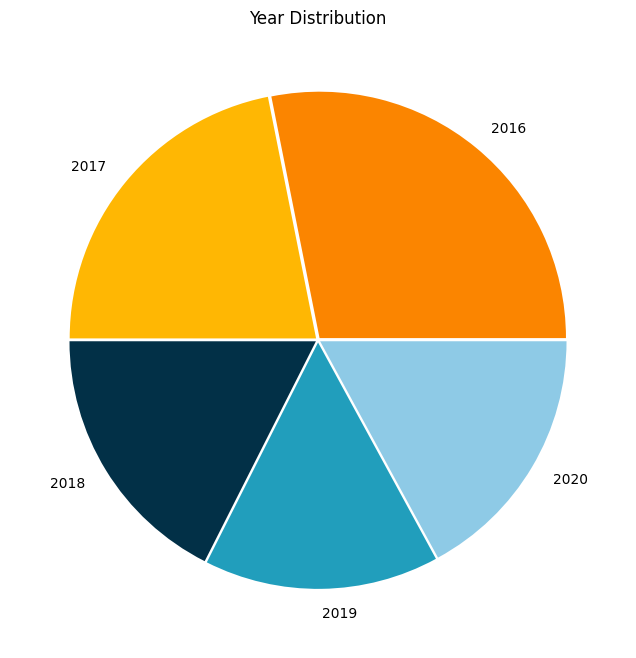

In [ ]:
plt.figure(figsize=(12,8))
plt.title('Year Distribution')
colors = ['#fb8500','#ffb703','#023047','#219ebc', '#8ecae6']
plt.pie(year_counts, labels=year_counts.index, explode = (0.01, 0.01, 0.01, 0.01, 0.01), colors = colors)
plt.savefig('year_pie_chart.png', dpi=300)
plt.show()

We now obtain data distribution per category.

In [ ]:
cat_counts = df['section'].value_counts()

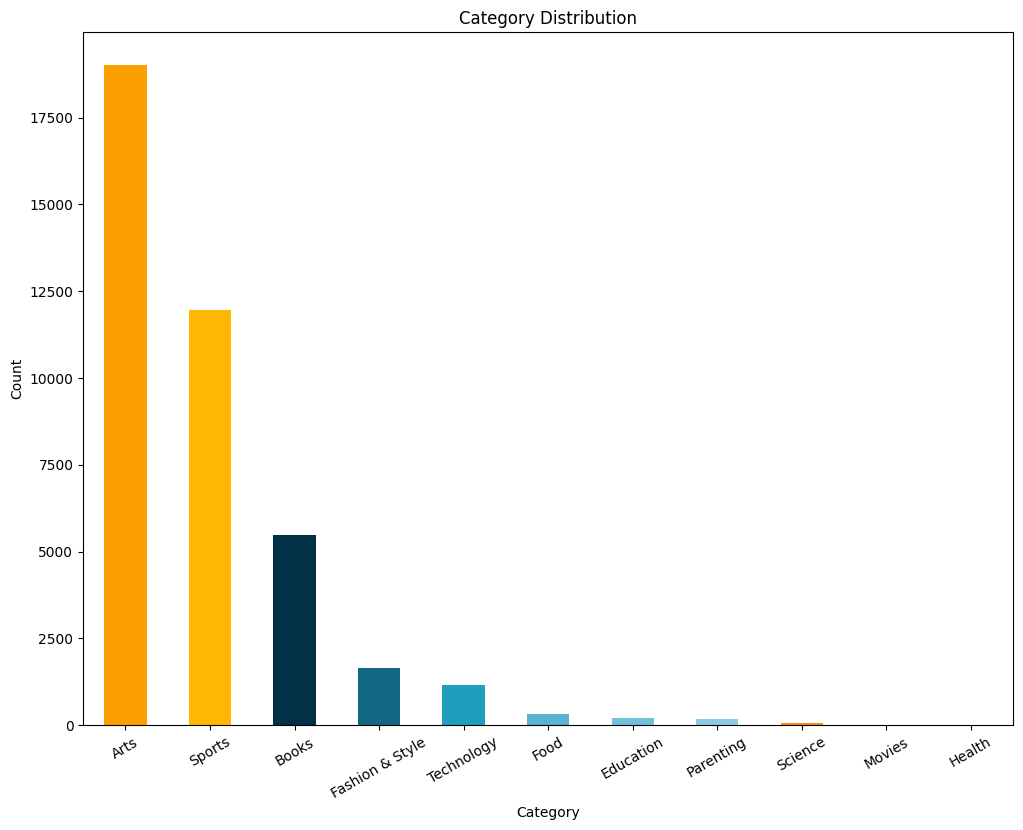

In [ ]:
plt.figure(figsize=(12,9))
plt.title('Category Distribution')
color = ['#fd9e02' ,'#ffb703', '#023047', '#126782', '#219ebc', '#58b4d1', '#73bfdc', '#8ecae6', '#fb9017', '#fb8500', '#fd9e02']
cat_counts.plot.bar(color=color)
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=30)
plt.grid(False)
plt.savefig('catd_dist.png', dpi=300)
plt.show()

In [ ]:
category_names = list(df['section'].unique())
print(category_names)

['Arts', 'Books', 'Fashion & Style', 'Sports', 'Technology', 'Food', 'Education', 'Parenting', 'Science', 'Movies', 'Health']


In [ ]:
df['keywords'] = df['keywords'].apply(ast.literal_eval)
df['keyword'] = df['keywords'].apply(lambda x: assign_category(x, category_names))

In [ ]:
keyword_count = df.keyword.value_counts()
keyword_count[:20]

Books and Literature        5323
Television                  3806
Baseball                    2694
Art                         2606
Movies                      1860
Dancing                     1748
Basketball                  1380
Music                       1332
Football                    1270
Pop and Rock Music          1037
Classical Music             1014
Soccer                       954
Tennis                       902
Weddings and Engagements     861
Deaths (Obituaries)          699
Opera                        669
Hockey, Ice                  668
Golf                         472
Rap and Hip-Hop              344
Museums                      338
Name: keyword, dtype: int64

Next, we obtain, for each article, a list of tokens representing the different sentences in the text body.

In [ ]:
sentences = []
df['sentences'] = df['article_body'].apply(lambda x: get_sentences(x))
for doc in df['article_body']:
    sentences += get_sentences(doc)
shuffle(sentences)

In [ ]:
df['sentences'] = df['sentences'].apply(flatten)

In [ ]:
male1 = set(male)
female1 = set(female)
df['man_freq'] = df['sentences'].apply(lambda x: len(set(x) & male1))
df['woman_freq'] = df['sentences'].apply(lambda x: len(set(x) & female1))

In [ ]:
df.to_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/df_sentence.csv')

## Part 2: Preliminary analysis
Based on the new features calculated above ('man' frequency and 'woman' frequency), we will now perform preliminary analysis on the possible presence of gender bias in the corpus. 

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/df_sentence.csv')

In [ ]:
selected_df = df[df["section"].isin(category_names)]
grouped = selected_df.groupby('section').sum()
grouped = grouped.drop(['year', 'author_id'], axis=1)
categories = grouped.index
man_counts = grouped['man_freq']
woman_counts = grouped['woman_freq']
print(grouped)

                 man_freq  woman_freq
section                              
Arts                20992       14675
Books                8102        6967
Education             208         128
Fashion & Style      1991        1475
Food                  145          59
Health                  1           0
Movies                 26          20
Parenting             129         350
Science                29           7
Sports              15295        4124
Technology            285         133


The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


In [ ]:
grouped.index

Index(['Arts', 'Books', 'Education', 'Fashion & Style', 'Food', 'Health',
       'Movies', 'Parenting', 'Science', 'Sports', 'Technology'],
      dtype='object', name='section')

In [ ]:

df_sorted_female = df.sort_values(by=['woman_freq'], ascending=False)

top_female_articles = df_sorted_female.head(10)


df_sorted_male = df.sort_values(by=['man_freq'], ascending=False)

top_male_articles = df_sorted_male.head(10)


print("Top articles with highest frequency of female seed words:")
for index, row in top_female_articles.iterrows():
    print("Title:", row['headline'])
    print("Category:", row['section'])
    print("Frequency of female seed words:", row['woman_freq'])
    print("Frequency of male seed words:", row['man_freq'])
    print()

# Print the titles, categories, and frequencies of the top male articles
print("Top articles with highest frequency of male seed words:")
for index, row in top_male_articles.iterrows():
    print("Title:", row['headline'])
    print("Category:", row['section'])
    print("Frequency of female seed words:", row['woman_freq'])
    print("Frequency of male seed words:", row['man_freq'])
    print()

Top articles with highest frequency of female seed words:
Title: Pink Quietly Became Pop Royalty. Here’s How She Made It Last.
Category: Arts
Frequency of female seed words: 6
Frequency of male seed words: 4

Title: Why Women Proposing Is Still Rare
Category: Fashion & Style
Frequency of female seed words: 6
Frequency of male seed words: 3

Title: ‘My Brilliant Friend’: A Fairy Tale of Youth Gives Way to Messy Adolescence
Category: Arts
Frequency of female seed words: 6
Frequency of male seed words: 2

Title: How Mirai Nagasu Grew Up and Got Back to the Olympics
Category: Sports
Frequency of female seed words: 6
Frequency of male seed words: 1

Title: Noah Davis Is Gone; His Paintings Continue to Hypnotize
Category: Arts
Frequency of female seed words: 6
Frequency of male seed words: 3

Title: The Best Movies and TV Shows New to Netflix, Amazon and More in April
Category: Arts
Frequency of female seed words: 6
Frequency of male seed words: 3

Title: A Roundup of the Season’s Romance No

In [ ]:
df_day = df.groupby(pd.Grouper(key='date', freq='D')).size().reset_index(name='count')

df_week = df.groupby(pd.Grouper(key='date', freq='W')).size().reset_index(name='count')


df_month = df.groupby(pd.Grouper(key='date', freq='M')).size().reset_index(name='count')

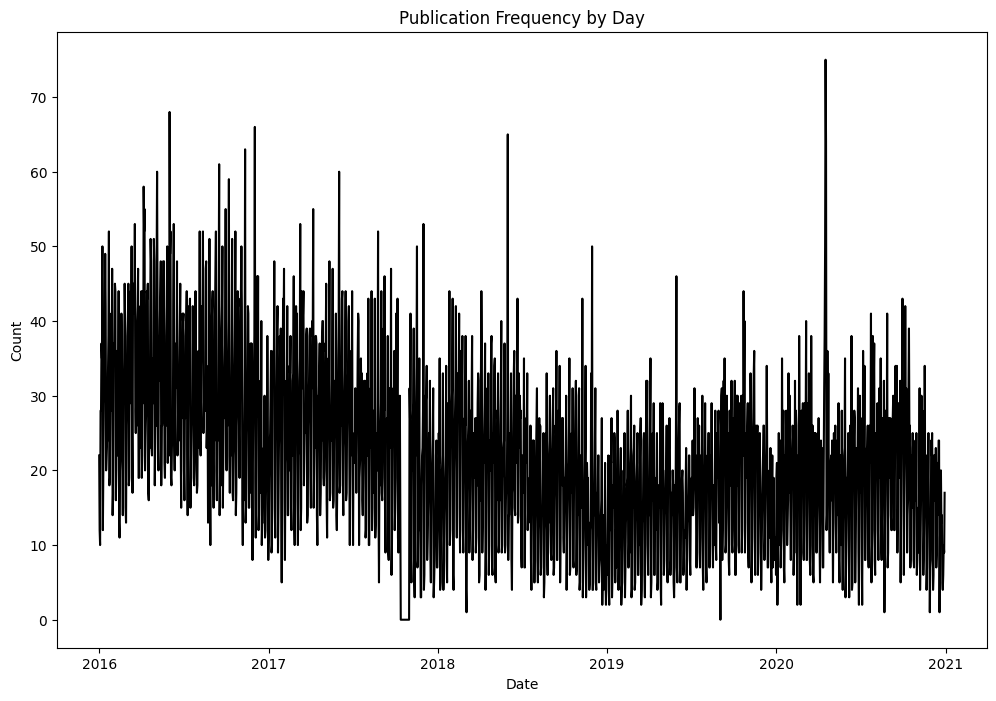

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df_day['date'], df_day['count'], color='black' )
plt.title('Publication Frequency by Day')
plt.xlabel('Date')
plt.ylabel('Count')
plt.savefig('pub_freq_day.png', dpi=300)
plt.show()

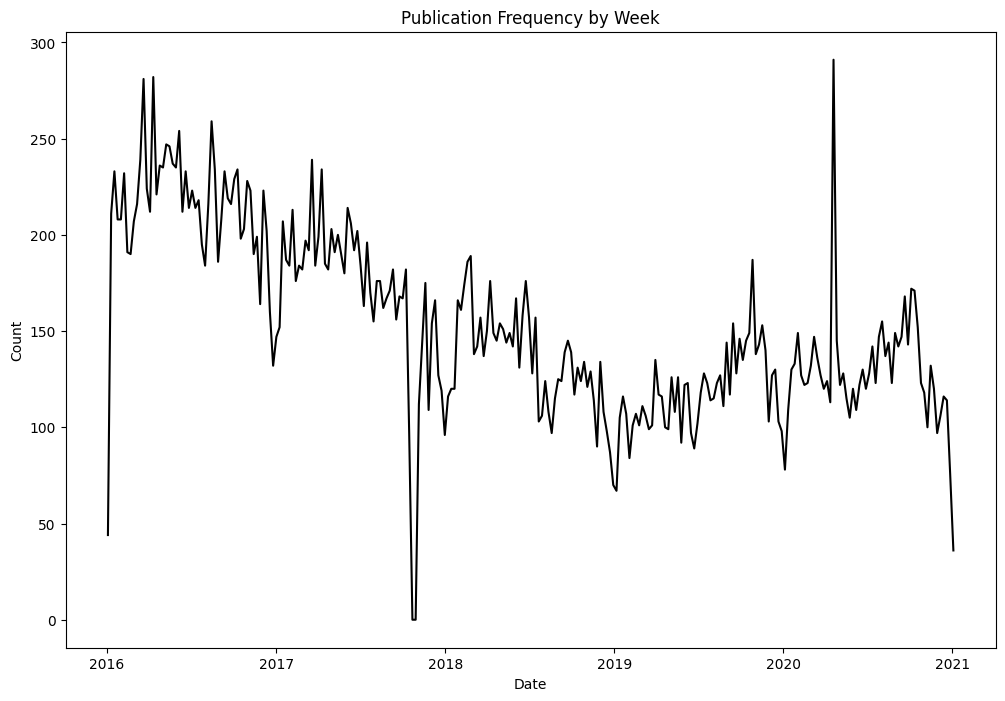

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df_week['date'], df_week['count'], color='black')
plt.title('Publication Frequency by Week')
plt.xlabel('Date')
plt.ylabel('Count')
plt.savefig('pub_freq_week.png', dpi=300)
plt.show()

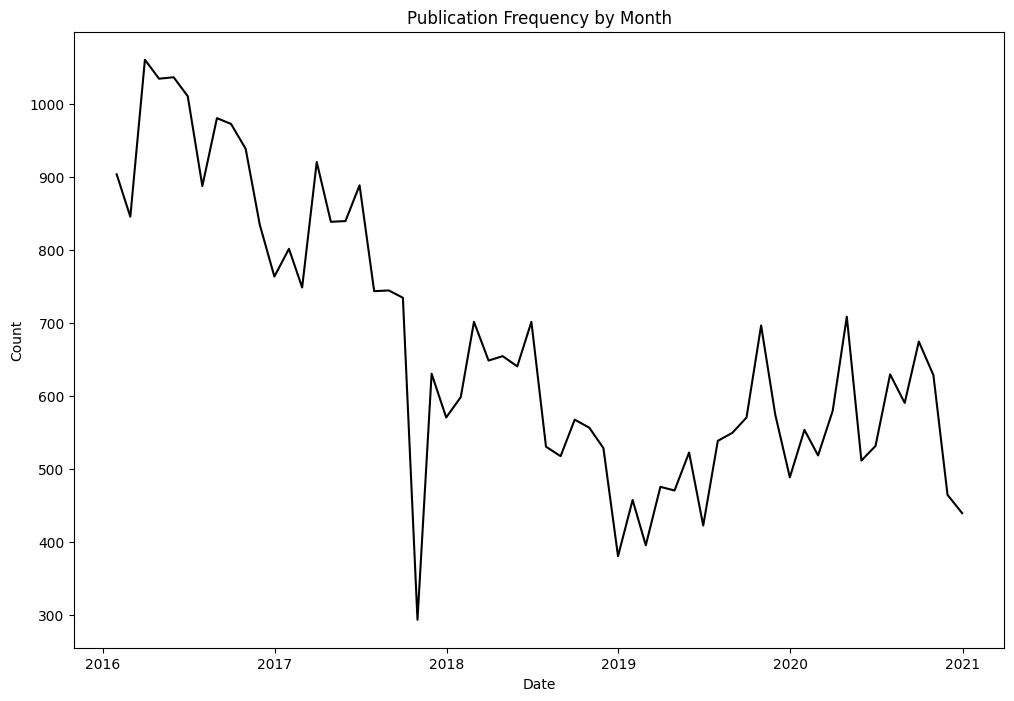

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(df_month['date'], df_month['count'], color='black')
plt.title('Publication Frequency by Month')
plt.xlabel('Date')
plt.ylabel('Count')
plt.savefig('pub_freq_month.png', dpi=300)
plt.show()

In [ ]:
text = ' '.join(df['article_body'])

In [ ]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white', colormap="viridis",
                stopwords = set(STOPWORDS),
                min_font_size = 10).generate(text)

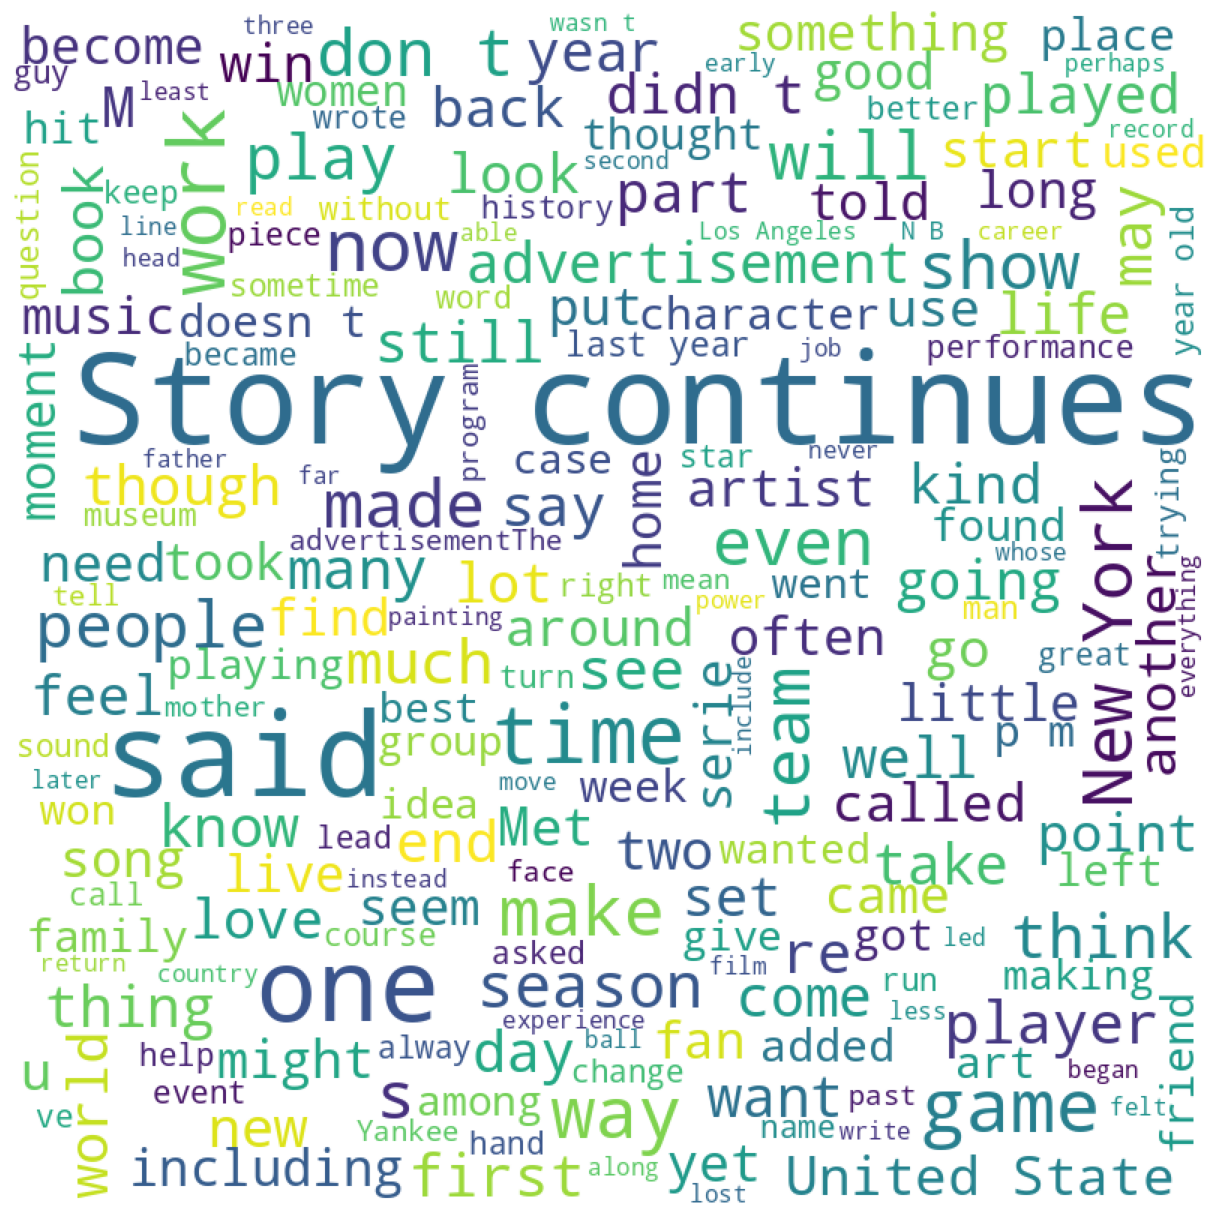

In [ ]:
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('wordcloud.png', dpi=300)
plt.show()

In [ ]:
authors_per_category = df.groupby('section')['author'].nunique()
print(authors_per_category)

section
Arts               1511
Books              2444
Education           108
Fashion & Style     255
Food                 22
Health                1
Movies                3
Parenting           108
Science              51
Sports              930
Technology          145
Name: author, dtype: int64


In [ ]:
from collections import Counter
grouped_data = df.groupby('section')
top_keywords = {}

for category, group in grouped_data:

    keyword_counts = Counter(keyword for keywords in group['keywords'] for keyword in keywords)
    
  
    top_keywords[category] = keyword_counts.most_common(5)
    

for category, keywords in top_keywords.items():
    print(f"Top 5 keywords in {category}:")
    for keyword, frequency in keywords:
        print(f"{keyword}: {frequency}")
    print()

Top 5 keywords in Arts:
Television: 6085
Art: 3239
Music: 2165
Dancing: 1982
Movies: 1772

Top 5 keywords in Books:
Books and Literature: 5447
Writing and Writers: 174
United States Politics and Government: 163
Poetry and Poets: 135
Blacks: 100

Top 5 keywords in Education:
Colleges and Universities: 155
Education (K-12): 46
Computers and the Internet: 21
E-Learning: 18
Careers and Professions: 15

Top 5 keywords in Fashion & Style:
Weddings and Engagements: 1055
Fashion and Apparel: 268
Marriages: 214
Dating and Relationships: 109
Men's Fashion Week: 74

Top 5 keywords in Food:
Wines: 196
Grapes: 57
Cocktails and Mixed Drinks: 54
ALCOHOLIC BEVERAGES: 43
Bars and Nightclubs: 32

Top 5 keywords in Health:
Teeth and Dentistry: 1
Brain: 1
Children and Childhood: 1
Voice and Speech: 1

Top 5 keywords in Movies:
Movies: 11
Video Releases (Entertainment): 9
DVD (Digital Versatile Disc): 2
Holocaust and the Nazi Era: 1
ANTI-SEMITISM: 1

Top 5 keywords in Parenting:
Parenting: 158
Babies and I

In [ ]:
# Group the data by section
grouped_sec_sub = df.groupby('section')

# Iterate over the groups
for section, group in grouped_sec_sub:
    # Get a set of unique subsection values for the section
    subsections = set(group['subsection'].unique())
    
    # Print the section and its subsections
    print(f"Section: {section}")
    print(f"Subsections: {subsections}\n")


Section: Arts
Subsections: {'Video Games', 'International Arts', 'Art & Design', 'Music', 'Dance', 'Arts', 'Television'}

Section: Books
Subsections: {'Books Update', 'Book Review'}

Section: Education
Subsections: {'Education Life', 'Learning'}

Section: Fashion & Style
Subsections: {'News', 'Weddings', 'Trends', 'Men’s Style', "Women's Runway", 'Beauty', 'Street'}

Section: Food
Subsections: {'Wine, Beer & Cocktails'}

Section: Health
Subsections: {'Health Guide'}

Section: Movies
Subsections: {'Movies', 'DVD'}

Section: Parenting
Subsections: {'Fertility', 'Baby', 'Guides', 'Big Kid', 'Toddler', 'Milestones', 'Pregnancy'}

Section: Science
Subsections: {'Space & Cosmos', 'Environment'}

Section: Sports
Subsections: {'College Basketball', 'Pro Basketball', 'Pro Football', 'Golf', 'Auto Racing', 'Baseball', 'International Sports', 'Cricket', 'Skiing', 'Horse Racing', 'Tennis', 'Soccer', 'World Cup', 'College Football', 'Olympics', 'Rugby', 'Sailing', 'Hockey', 'Cycling'}

Section: Tec

In [ ]:
# Get a set of unique values in the 'doc type' column
doc_types = set(df['material_type'].unique())

# Print the unique doc types
print("Unique Doc Types:")
for doc_type in doc_types:
    print(doc_type)


Unique Doc Types:
Special Report
News
Schedule
Video
Interview
Brief
Obituary (Obit)
Interactive Feature
briefing
Text
Question
Biography
News Analysis
List
Review
Slideshow
Op-Ed
An Appraisal


In [ ]:
# Define a function to count the number of words in an article
def count_words(article_body):
    return len(article_body.split())

# Apply the function to the 'article_body' column to get the article length
df['article_length'] = df['article_body'].apply(count_words)

# Group the data by section
grouped_data = df.groupby('section')

# Calculate the mean of the article length column for each group
mean_article_length = grouped_data['article_length'].mean()

# Print the average article length for each section
print("Average Article Length by Section:")
print(mean_article_length)


Average Article Length by Section:
section
Arts                863.379011
Books               976.108878
Education          1317.004902
Fashion & Style    1075.395504
Food               1050.581602
Health               49.000000
Movies             2123.181818
Parenting          1561.176471
Science             477.478873
Sports             1010.558501
Technology          625.312287
Name: article_length, dtype: float64


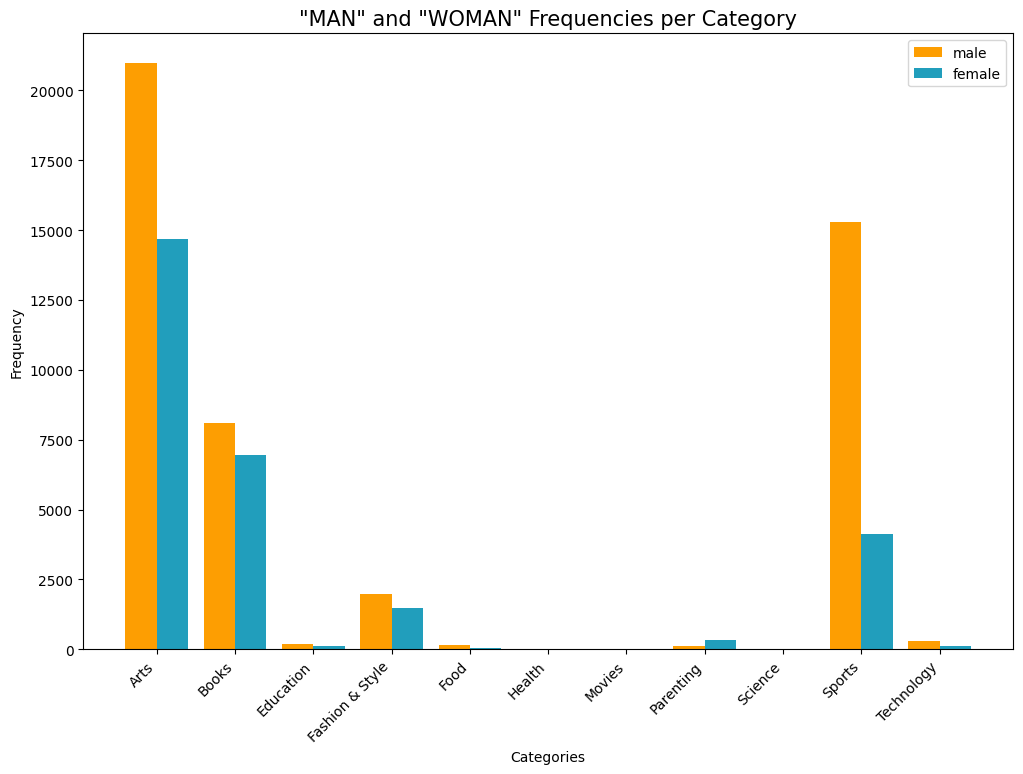

In [ ]:
x = np.arange(len(category_names))


plt.figure(figsize=(12,8))
width = 0.4
plt.bar(x-0.2, grouped['man_freq'],
        width, color='#fd9e02', label='male')
plt.bar(x+0.2, grouped['woman_freq'],
        width, color='#219ebc', label='female')
plt.title('"MAN" and "WOMAN" Frequencies per Category', fontsize=15)
plt.xticks(ticks=x, labels=grouped.index, fontsize=10)
plt.xlabel('Categories')
plt.ylabel('Frequency')

plt.xticks(fontsize=10, rotation = 45, ha='right')
plt.yticks(fontsize=10)
plt.grid(False)
plt.tick_params(bottom=True, left=True)
plt.legend()
plt.legend(frameon=True, fontsize=10)
plt.savefig('man_woman_frequency.png', dpi=300)
plt.show()

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


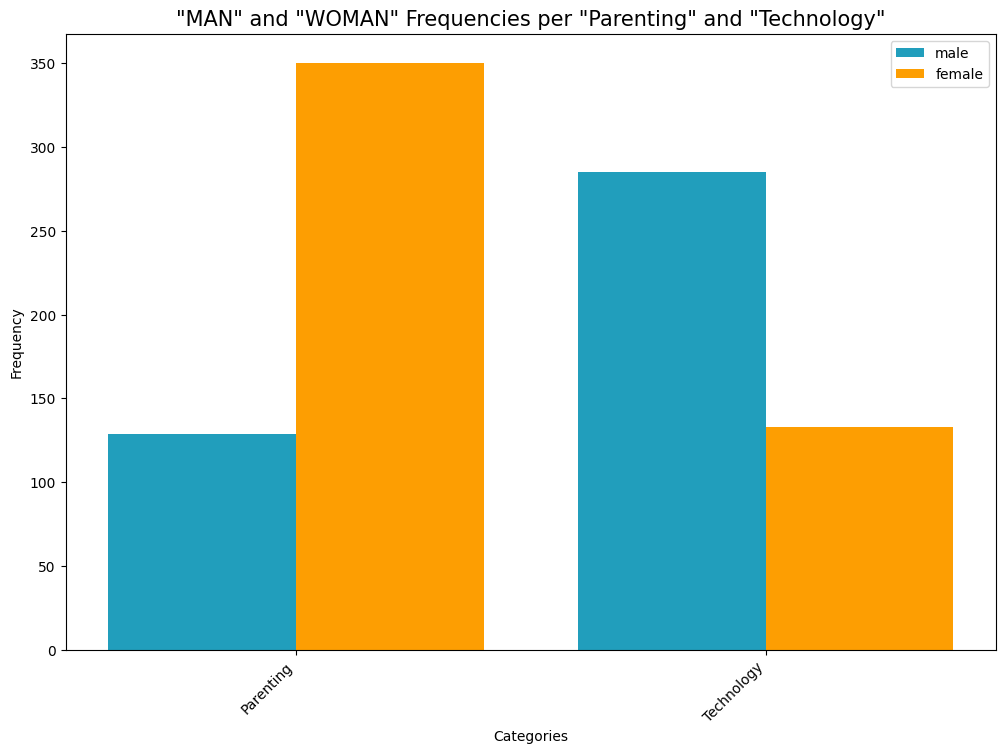

In [ ]:
just = ['Parenting', 'Technology']
x = np.arange(len(just))
selected_df_2 = df[df["section"].isin(just)]
grouped_2 = selected_df_2.groupby('section').sum()
categories_2 = grouped_2.index
man_counts_2 = grouped_2['man_freq']
woman_counts_2 = grouped_2['woman_freq']


plt.figure(figsize=(12,8))
width = 0.4
plt.bar(x-0.2, grouped_2['man_freq'],
        width, color='#219ebc', label='male')
plt.bar(x+0.2, grouped_2['woman_freq'],
        width, color='#fd9e02', label='female')
plt.title('"MAN" and "WOMAN" Frequencies per "Parenting" and "Technology"', fontsize=15)
plt.xticks(ticks=x, labels=just, fontsize=10)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.xticks(fontsize=10, rotation = 45, ha='right')
plt.yticks(fontsize=10)

plt.tick_params(bottom=True, left=True)
plt.legend()
plt.legend(frameon=True, fontsize=10)
plt.savefig('man_woman_frequency_cat.png', dpi=300)
plt.show()

## Part 3: Word Embeddings
Train a word2vec model to extract word representations.

Next, we will train the word2vec model as described in the paper. 

In [ ]:
num_words= 300
w2v = Word2Vec(sentences,  
              workers = 8, 
               size = num_words,    
               min_count =  1, 
               window = 5, 
               sample = 1e-3
               )

w2v.init_sims(replace=True)
w2v.save('/content/drive/MyDrive/[4] Final Paper 2023, BSc/w2v-vectors')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/df_sentence.csv')

In [ ]:
model = Word2Vec.load('/content/drive/MyDrive/[4] Final Paper 2023, BSc/w2v-vectors')

We define seed words that will be used to evaluate the gender dimension in the corpus.

In [ ]:
seed_words = ['man', 'woman', 'boy', 'girl', 'he', 'she', 'they', 'person', 'peopl', 'pink', 'blue', 'child', 'career']
female = ['woman', 'girl', 'she', 'pink', 'women','her', 'child', 'famil']
male = ['man', 'boy', 'he', 'blue', 'men', 'him', 'career', 'money']

categories = df['section'].unique()
category_names = list(categories)
category_names

['Arts',
 'Books',
 'Fashion & Style',
 'Sports',
 'Technology',
 'Food',
 'Education',
 'Parenting',
 'Science',
 'Movies',
 'Health']

Example of a 300-dimensional vector (for the word 'woman').

In [ ]:
print(f"vector for 'woman' is: {model.wv['woman']}")

vector for 'woman' is: [-1.10575676e-01 -1.66857298e-02  3.06969811e-03  7.12805390e-02
  3.61023657e-02  5.17503247e-02  3.11556142e-02 -3.40136676e-03
  6.66129366e-02  3.09798867e-02  1.10330507e-02  4.70635891e-02
  1.61507372e-02  4.87488359e-02 -7.59974346e-02  8.42615813e-02
 -9.78384688e-02  3.83126410e-03 -3.26378942e-02 -1.85644701e-02
  2.12775171e-02 -9.97548774e-02  3.14830281e-02  3.32372673e-02
 -1.06722787e-01 -6.15398325e-02  5.21805659e-02  1.42238000e-02
  9.71224234e-02  4.98998128e-02  4.48525790e-03  8.44733939e-02
  2.06737965e-02 -5.97063862e-02 -1.38766430e-02 -1.18994243e-01
 -1.28568644e-02  1.70313928e-03  8.19550827e-03  6.01218268e-02
  6.92317411e-02 -8.46415162e-02  9.47037414e-02 -6.77309334e-02
  8.05735216e-03 -7.46943653e-02  5.16743176e-02  2.11874880e-02
 -1.20176367e-01 -2.71656755e-02  1.46301510e-02  5.22129498e-02
  4.62186076e-02 -8.34640488e-02 -5.12446463e-03  1.19435135e-02
  3.11713107e-02 -7.64138028e-02  2.77177077e-02 -7.84699321e-02
  

In [ ]:
print(f"similarity between 'woman' and 'man' is: {model.wv.similarity('woman','man')}") 

similarity between 'woman' and 'man' is: 0.6774794459342957


In [ ]:
print(f"most similar words to 'woman' are: {model.wv.most_similar('woman')}") 

most similar words to 'woman' are: [('man', 0.6774795055389404), ('girl', 0.6016279458999634), ('women', 0.5520017147064209), ('child', 0.5460309386253357), ('heroin', 0.5427878499031067), ('she', 0.5230186581611633), ('prostitut', 0.5165742039680481), ('protagonist', 0.5148749351501465), ('widow', 0.5119574069976807), ('schoolgirl', 0.5051826238632202)]


We will now obtain vector representations for each seed word and evaluate the gender dimension.

In [ ]:
word_vectors = {x: model.wv[x] for x in seed_words}
male_vectors = {x: model.wv[x] for x in male}
female_vectors = {x: model.wv[x] for x in female}

In [ ]:
gender_dimension = np.mean(np.array(list(male_vectors.values())), axis=0) - np.mean(np.array(list(female_vectors.values())), axis=0)
type(gender_dimension)

numpy.ndarray

## Part 4: Textual feature extraction
Perform feature extraction for multinomial classification.

In [ ]:
df_s = df

In [ ]:
df_s['section'].unique()

array(['Arts', 'Books', 'Fashion & Style', 'Sports', 'Technology', 'Food',
       'Education', 'Parenting', 'Science', 'Movies', 'Health'],
      dtype=object)

In [ ]:
len(df_s)

40070

In [ ]:
df_s['avg_embedding'] = df_s['sentences'].apply(lambda x: get_average_embedding(x, model))

In [ ]:
df_s['cos_sim_gender_bias'] = df_s['avg_embedding'].apply(lambda x: cosine_similarity([x], [gender_dimension])[0][0])

In [ ]:
df_s['article_body_len'] = df_s['article_body'].apply(lambda x: len(x))

In [ ]:
df_s['headline_embedding'] = df_s['headline'].apply(lambda x: get_average_embedding(x, model))

In [ ]:
df_s['lead_parag_embedding'] = df_s['lead_paragraph'].apply(lambda x: get_average_embedding(x, model))

In [ ]:
headline_embedding_array = np.array(df_s['headline_embedding'].tolist())

In [ ]:
lead_paragraph_array = np.array(df_s['lead_parag_embedding'].tolist())

In [ ]:
pca = PCA(n_components=1)
df_s['headline_embedding_scalar'] = pca.fit_transform(headline_embedding_array)

In [ ]:
df_s['lead_para_embedding_scalar'] = pca.fit_transform(lead_paragraph_array)

In [ ]:
df_s.to_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/[3] Data/[0] CSV files/pre_processed_data.csv')

## Part 5: Correlation calculation and label encoder
Calculate correlation and assign number to each category with a label encoder.

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/[3] Data/[0] CSV files/pre_processed_data.csv', index_col=0)

In [ ]:
data = data[data.section != 'Health']
data = data[data.section != 'Movies']

In [ ]:
le = LabelEncoder()
data['category'] = le.fit_transform(data['section'])

In [ ]:
df_correlation = data[['category', 'year', 'cos_sim_gender_bias', 'article_body_len','man_freq', 'woman_freq', 'headline_embedding_scalar', 'lead_para_embedding_scalar']]

corr = df_correlation.corr()
corr.index = ['Category', 'Year', 'Bias', 'Article Length', 'Man Frequency', 'Woman Frequency', 'Headline Emb', 'Lead Par Emb', ]
corr.columns = ['Category', 'Year',  'Bias', 'Article Length', 'Man Frequency', 'Woman Frequency', 'Headline Emb', 'Lead Par Emb']

fig, ax = plt.subplots(figsize=(14, 14))
sns.set(font_scale=1.2)
sns.heatmap(corr, annot=True, cmap='Oranges', ax=ax,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot_kws={'fontsize': 12}, square=True, linewidths=.5, cbar_kws={"shrink": .5})

ax.set_xticklabels(ax.get_xticklabels(), ha='right', fontsize=12)
ax.set_yticklabels(ax.get_yticklabels(),  ha='right', fontsize=12)
plt.title('Correlation matrix')
plt.savefig('corre.png', dpi=300)
plt.show()

## Part 6: Obtaining dummy variables
Obtain dummy variables for 'year' and 'material type'

In [ ]:
material_dummies = pd.get_dummies(data['material_type'])
year_dummies = pd.get_dummies(data['year'])

data = pd.concat([data['category'], data['article_body_len'], data['cos_sim_gender_bias'], data['headline_embedding_scalar'], data['lead_para_embedding_scalar'], data['man_freq'], data['woman_freq'], material_dummies, year_dummies], axis=1)

In [ ]:
data.to_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/[3] Data/[0] CSV files/data_for_transformer.csv')

## Part 7: Feature transformation and target identification
Scale feature using a min-max scaler, separate X and y to obtain features and targets.


In [ ]:
data_2 = pd.read_csv('/content/drive/MyDrive/[4] Final Paper 2023, BSc/[3] Data/[0] CSV files/data_for_transformer.csv')

In [ ]:
data_2 = data_2.drop(['Unnamed: 0'], axis=1)

In [ ]:
X = data_2.drop(['category'], axis=1)

In [ ]:
X.head()

,article_body_len,cos_sim_gender_bias,headline_embedding_scalar,lead_para_embedding_scalar,man_freq,woman_freq,An Appraisal,Biography,Brief,Interactive Feature,...,Slideshow,Special Report,Text,Video,briefing,2016,2017,2018,2019,2020
0,1876,-0.028193,0.057047,0.029590,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,4901,-0.041034,0.002880,-0.051496,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2907,-0.029021,-0.064319,-0.019808,2,3,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,9478,-0.031501,0.019253,0.012978,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,10120,-0.037920,-0.003392,-0.001715,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
y = data_2['category']

In [ ]:
scaler = MinMaxScaler()

In [ ]:
X.columns = X.columns.astype(str)

In [ ]:
transformer = ColumnTransformer(transformers=[('scaler', scaler,[0])], remainder="passthrough") 
X_trans = pd.DataFrame(transformer.fit_transform(X), columns = X.columns)

In [ ]:
X_trans['year'] = X_trans.loc[:, '2016':'2020'].idxmax(axis=1).str[-4:].astype(int)

In [ ]:
X_trans.head()

,article_body_len,cos_sim_gender_bias,headline_embedding_scalar,lead_para_embedding_scalar,man_freq,woman_freq,An Appraisal,Biography,Brief,Interactive Feature,...,Special Report,Text,Video,briefing,2016,2017,2018,2019,2020,year
0,0.021281,-0.028193,0.057047,0.029590,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019
1,0.055911,-0.041034,0.002880,-0.051496,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019
2,0.033084,-0.029021,-0.064319,-0.019808,2.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019
3,0.108308,-0.031501,0.019253,0.012978,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019
4,0.115657,-0.037920,-0.003392,-0.001715,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2019


In [ ]:
sample_idx_d = np.random.choice(X_trans.shape[0], 5000, replace=False)
sample_d = X_trans.iloc[sample_idx_d]
sample_d_y = y.iloc[sample_idx_d]

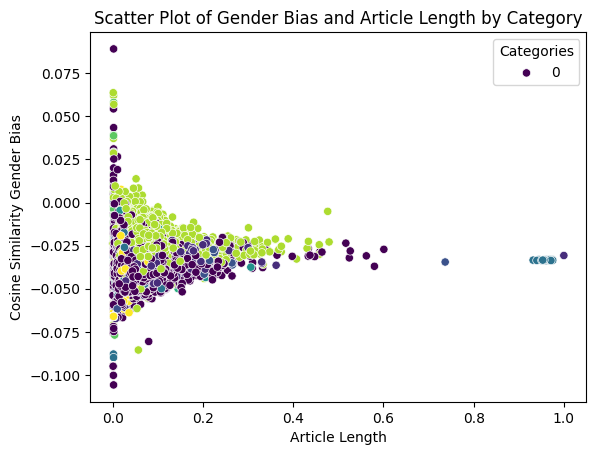

In [ ]:
sns.scatterplot(x='article_body_len', y='cos_sim_gender_bias', c=y, data=X_trans, cmap='viridis' )
plt.xlabel('Article Length')
plt.ylabel('Cosine Similarity Gender Bias')
plt.title('Scatter Plot of Gender Bias and Article Length by Category')
plt.legend(title='Categories', labels=['0', '1', '2', '3', '4', '5', '6', '7'])
plt.show()

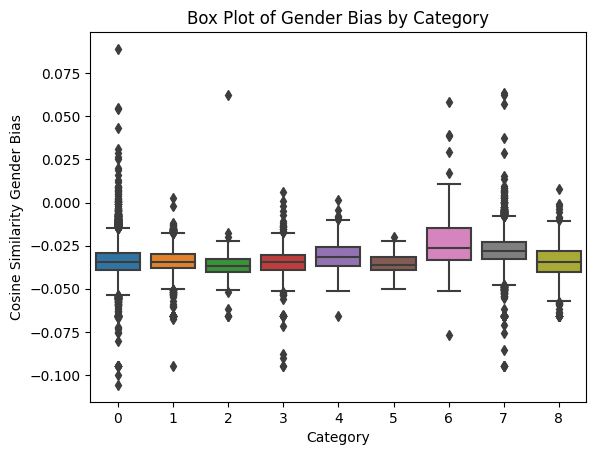

In [ ]:
sns.boxplot(x=y, y='cos_sim_gender_bias', data=X_trans)
plt.xlabel('Category')
plt.ylabel('Cosine Similarity Gender Bias')
plt.title('Box Plot of Gender Bias by Category')
plt.show()

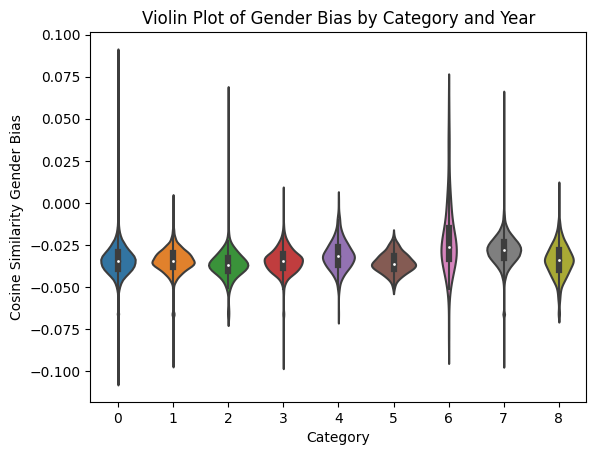

In [ ]:
sns.violinplot(x=y, y='cos_sim_gender_bias', c='year', data=X_trans, cmap='viridis', split=True)
plt.xlabel('Category')
plt.ylabel('Cosine Similarity Gender Bias')
plt.title('Violin Plot of Gender Bias by Category and Year')
plt.show()

Text(0, 0.5, 'cos_sim_gender_bias')

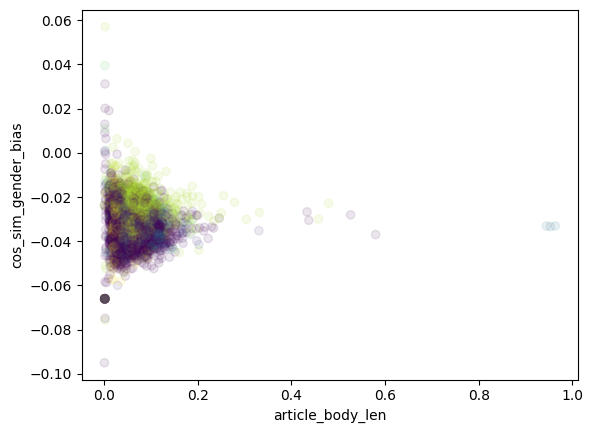

In [ ]:
plt.scatter(sample_d['article_body_len'], sample_d['cos_sim_gender_bias'], alpha=0.1, c=sample_d_y, cmap='viridis')
plt.xlabel('article_body_len')
plt.ylabel('cos_sim_gender_bias')

In [ ]:
y.unique()

array([0, 1, 3, 7, 8, 4, 2, 5, 6])

## Part 8: Train/Test split
Divide the dataset in training and testing dataset with 0.8 / 0.2 proportions.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=2)

## Part 9: Training the models on the imbalanced dataset

Train Softmax classifier, random forest classifier and multi-layer perceptron on the imbalanced dataset. Evaluate performance, confusion matrix and classification report for each model.

### Softmax classifier

In [ ]:
reg = LogisticRegression(max_iter=1000, random_state=2, multi_class='ovr', solver='liblinear')
reg.fit(X_train, y_train)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=2,
                   solver='liblinear')

In [ ]:
preds_lr = reg.predict(X_test)
prob_lr = reg.predict_proba(X_test)

In [ ]:
print(f'Mean Squared Error is: {mean_squared_error(y_test, preds_lr)}')
print(f'Accuracy score is: {accuracy_score(y_test, preds_lr)}')

Mean Squared Error is: 11.449700449326011
Accuracy score is: 0.6323015476784822


In [ ]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=preds_lr)

In [ ]:
cm_lr, cmn_lr = calculate_cm(y_test, preds_lr)
plt.figure(figsize=(12,12))
sns.heatmap(cmn_lr, xticklabels=np.arange(9), yticklabels = np.arange(9), annot=True, cmap="Oranges", fmt=".3f", linewidth=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Softmax classifier')
plt.savefig('corr_matrix_lr.png', dpi=300)
plt.show()

print(f'Mean Squared Error is: {mean_squared_error(y_test, preds_lr)}')
print(f'Accuracy score is: {accuracy_score(y_test, preds_lr)}')

In [ ]:
classification_report_lr = classification_report(y_test, preds_lr, digits=2, output_dict=True)

report_df = pd.DataFrame(classification_report_lr).transpose()
report_df.reset_index(inplace=True)
report_df.rename(columns={'index': 'Class'}, inplace=True)

with open('log_reg_report.tex', 'w') as f:
    f.write(tabulate(report_df, headers='keys', tablefmt='latex_booktabs'))

In [ ]:
feature_names = X_train.columns

coefficients_lr = {}
for i, feature_name in enumerate(feature_names):
    coefficients_lr[feature_name] = reg.coef_[0][i]
print(coefficients_lr)
coefficients_lr = dict(sorted(coefficients_lr.items(), key=lambda x: x[1], reverse=True))

print(coefficients_lr)

{'article_body_len': -6.885626069449479, 'cos_sim_gender_bias': -17.31440962448193, 'headline_embedding_scalar': -1.2699911813026652, 'lead_para_embedding_scalar': 3.4174247393402575, 'man_freq': -0.10468926674100854, 'woman_freq': 0.22637567200781994, 'An Appraisal': 1.32677822138508, 'Biography': 0.4512141779724249, 'Brief': -1.3457268359083732, 'Interactive Feature': -0.7522630992267242, 'Interview': 2.6437814161799507, 'List': -3.8605579613378542, 'News': 0.12880627061865582, 'News Analysis': -0.2786233280544941, 'Obituary (Obit)': 1.4322279476188498, 'Op-Ed': -0.3783809186040659, 'Question': -2.0746263853616247, 'Review': 0.07888001119943482, 'Schedule': 5.236510762591224, 'Slideshow': -1.4858672813800622, 'Special Report': -0.11901338717619131, 'Text': -0.23138575555794486, 'Video': 0.20466367424755036, 'briefing': -1.2913689855427624, '2016': -0.26791939322986374, '2017': -0.23011581514444812, '2018': 0.07604157816212004, '2019': 0.2637144260351381, '2020': -0.15667225217482894}

### Random forest classifier

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 2)
rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=2)

In [ ]:
preds_rf = rf.predict(X_test)
prob_rf = rf.predict_proba(X_test)

In [ ]:
conf_matrix_rf = confusion_matrix(y_test, preds_rf)
cm_rf, cmn_rf = calculate_cm(y_test, preds_rf)
plt.figure(figsize=(12,12))
sns.heatmap(cmn_rf, xticklabels=np.arange(9), yticklabels = np.arange(9), annot=True, cmap="Oranges", fmt=".3f", linewidth=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Random forest')
plt.savefig('corr_matrix_rf.png', dpi=300)
plt.show()

print(f'Mean Squared Error is: {mean_squared_error(y_test, preds_rf)}')
print(f'Accuracy score is: {accuracy_score(y_test, preds_rf)}')

In [ ]:
classification_report_rf = classification_report(y_test, preds_rf, digits=2, output_dict=True)

report_df = pd.DataFrame(classification_report_rf).transpose()
report_df.reset_index(inplace=True)
report_df.rename(columns={'index': 'Class'}, inplace=True)

with open('random_forest_report.tex', 'w') as f:
    f.write(tabulate(report_df, headers='keys', tablefmt='latex_booktabs'))

In [ ]:
feature_importance_rf = rf.feature_importances_

coefficients_rf = {}
for i, feature_name in enumerate(feature_names):
    coefficients_rf[feature_name] = feature_importance_rf[i]
print(coefficients_rf)
coefficients_rf = dict(sorted(coefficients_rf.items(), key=lambda x: x[1], reverse=True))

print(coefficients_rf)

{'article_body_len': 0.18872653970926934, 'cos_sim_gender_bias': 0.1748262312504875, 'headline_embedding_scalar': 0.13339130937939375, 'lead_para_embedding_scalar': 0.1519364044117164, 'man_freq': 0.04514692685410267, 'woman_freq': 0.0496974912828339, 'An Appraisal': 9.239500015586822e-05, 'Biography': 5.23157986728647e-06, 'Brief': 0.00014077186508869213, 'Interactive Feature': 0.0049736437822946915, 'Interview': 0.0003801029339965657, 'List': 0.013791778356905962, 'News': 0.06730547988712555, 'News Analysis': 0.00010703915243818985, 'Obituary (Obit)': 0.006311909884328777, 'Op-Ed': 3.316466286665495e-05, 'Question': 0.02918082852737552, 'Review': 0.07654184464803437, 'Schedule': 0.009457285481100305, 'Slideshow': 0.0002654334750531608, 'Special Report': 8.502983449195324e-05, 'Text': 3.2726299581947464e-05, 'Video': 0.0013908093977242737, 'briefing': 0.000290881545185521, '2016': 0.011366683739013391, '2017': 0.008258707523268228, '2018': 0.007160190473245922, '2019': 0.0082865611558

### Multi-layer perceptron

In [ ]:
input_shape = len(X.columns)
num_classes = len(y.unique())

In [ ]:
y_train_cat = to_categorical(y_train, num_classes = num_classes)
y_test_cat = to_categorical(y_test, num_classes = num_classes)

In [ ]:
model = Sequential()
model.add(Dense(60, input_shape = (input_shape,) , activation = "relu"))
model.add(Dense(80, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation = "softmax"))
model.compile(Adam(lr = 0.01), "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 60)                1800      
                                                                 
 dense_1 (Dense)             (None, 80)                4880      
                                                                 
 dropout (Dropout)           (None, 80)                0         
                                                                 
 dense_2 (Dense)             (None, 9)                 729       
                                                                 
Total params: 7,409
Trainable params: 7,409
Non-trainable params: 0
_________________________________________________________________


The `lr` argument is deprecated, use `learning_rate` instead.


In [ ]:
model.fit(X_train, y_train_cat, verbose=1, epochs=10)

Epoch 1/10
1002/1002 [==============================] - 8s 4ms/step - loss: 0.9825 - accuracy: 0.5962
Epoch 2/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.9376 - accuracy: 0.6239
Epoch 3/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.9162 - accuracy: 0.6351
Epoch 4/10
1002/1002 [==============================] - 4s 4ms/step - loss: 0.8980 - accuracy: 0.6488
Epoch 5/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.8882 - accuracy: 0.6544
Epoch 6/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.8780 - accuracy: 0.6580
Epoch 7/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.8710 - accuracy: 0.6651
Epoch 8/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.8639 - accuracy: 0.6689
Epoch 9/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.8627 - accuracy: 0.6703
Epoch 10/10
1002/1002 [==============================] - 3s 3ms/step - loss: 0.857

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print('Validation accuracy:', accuracy)

251/251 [==============================] - 1s 2ms/step - loss: 0.8592 - accuracy: 0.6700
Validation accuracy: 0.6699950098991394


In [ ]:
y_pred = pd.Series(np.argmax(model.predict(X_test), axis=1))

cm = confusion_matrix(y_test, y_pred)
cmn = cm/cm.sum(axis=1)
print(cmn)

251/251 [==============================] - 0s 1ms/step
[[8.05772231e-01 1.73994387e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 9.09090909e-02 4.76190476e-02 2.30737018e-01
  2.80373832e-02]
 [1.11024441e-01 5.83723106e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.53768844e-03
  0.00000000e+00]
 [8.58034321e-03 9.35453695e-04 0.00000000e+00 2.92397661e-03
  0.00000000e+00 3.03030303e-02 0.00000000e+00 4.18760469e-04
  4.67289720e-03]
 [6.96827873e-02 1.87090739e-03 0.00000000e+00 8.77192982e-03
  0.00000000e+00 3.03030303e-02 0.00000000e+00 2.84757119e-02
  0.00000000e+00]
 [1.09204368e-02 9.35453695e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 7.53768844e-03
  0.00000000e+00]
 [5.20020801e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 3.93939394e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [3.90015601e-03 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(cmn, xticklabels=np.arange(9), yticklabels = np.arange(9), annot=True, cmap="Oranges", fmt=".3f", linewidth=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multi-layer perceptron')
plt.savefig('corr_matrix_nn.png', dpi=300)
plt.show()

In [ ]:
classification_report_nn = classification_report(y_test, y_pred, digits=2, output_dict=True)

report_nn = pd.DataFrame(classification_report_nn).transpose()
report_nn.reset_index(inplace=True)
report_nn.rename(columns={'index': 'Class'}, inplace=True)

with open('neural_network_report.tex', 'w') as f:
    f.write(tabulate(report_nn, headers='keys', tablefmt='latex_booktabs'))

In [ ]:
weights = model.layers[0].get_weights()[0]
abs_mean_weights = weights.mean(axis=1)

In [ ]:
print(abs_mean_weights)

[-1.2713519   1.0931013  -0.01407533 -0.65306073 -0.26320067 -0.2946803
  0.08751936 -0.03293492  0.01082296 -0.19771053  0.05999911 -0.04597109
 -0.5555634   0.01237857 -0.2142853   0.03404387 -0.21411265 -0.3272409
  0.27476704  0.0116758  -0.06597417  0.01051071 -0.20110886  0.07343151
 -0.2227079  -0.24818467 -0.08219506 -0.04277118 -0.15946504]


In [ ]:
feature_names = X_train.columns

In [ ]:
feature_importance_nn = abs_mean_weights

coefficients_nn = {}
for i, feature_name in enumerate(feature_names):
    coefficients_nn[feature_name] = feature_importance_nn[i]
print(coefficients_nn)
coefficients_nn = dict(sorted(coefficients_nn.items(), key=lambda x: x[1], reverse=True))

print(coefficients_nn)


{'article_body_len': -1.2713519, 'cos_sim_gender_bias': 1.0931013, 'headline_embedding_scalar': -0.014075326, 'lead_para_embedding_scalar': -0.65306073, 'man_freq': -0.26320067, 'woman_freq': -0.2946803, 'An Appraisal': 0.08751936, 'Biography': -0.03293492, 'Brief': 0.0108229555, 'Interactive Feature': -0.19771053, 'Interview': 0.05999911, 'List': -0.04597109, 'News': -0.5555634, 'News Analysis': 0.012378569, 'Obituary (Obit)': -0.2142853, 'Op-Ed': 0.034043867, 'Question': -0.21411265, 'Review': -0.3272409, 'Schedule': 0.27476704, 'Slideshow': 0.011675805, 'Special Report': -0.06597417, 'Text': 0.010510711, 'Video': -0.20110886, 'briefing': 0.07343151, '2016': -0.2227079, '2017': -0.24818467, '2018': -0.08219506, '2019': -0.042771183, '2020': -0.15946504}
{'cos_sim_gender_bias': 1.0931013, 'Schedule': 0.27476704, 'An Appraisal': 0.08751936, 'briefing': 0.07343151, 'Interview': 0.05999911, 'Op-Ed': 0.034043867, 'News Analysis': 0.012378569, 'Slideshow': 0.011675805, 'Brief': 0.010822955

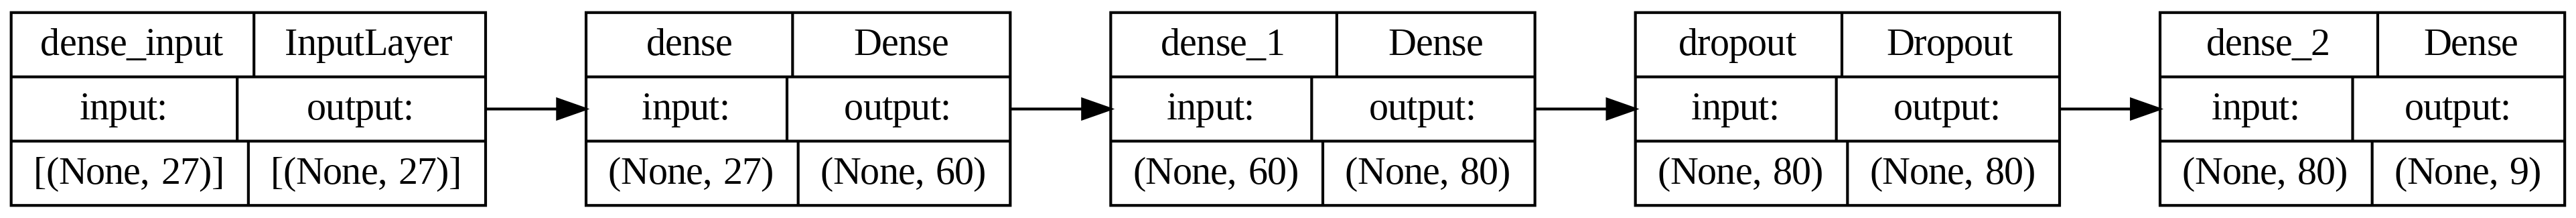

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR", to_file='model.png', dpi=300)

## Part 10: Oversampling
Using the random oversampler, resample the imbalanced dataset. Perform a new train / test split.

In [ ]:
ros = RandomOverSampler(random_state=2)
X_resampled, y_resampled = ros.fit_resample(X_trans, y)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=2)

## Part 11: Training the models on the balanced dataset
Train Softmax classifier, random forest classifier and multi-layer perceptron on the balanced dataset. Evaluate performance, confusion matrix and classification report for each model.

### Balanced softmax classifier

In [ ]:
reg_bal = LogisticRegression(max_iter=1000, random_state=2, multi_class='ovr', solver='liblinear')
reg_bal.fit(X_train_r, y_train_r)

LogisticRegression(max_iter=1000, multi_class='ovr', random_state=2,
                   solver='liblinear')

In [ ]:
preds_lr_b = reg_bal.predict(X_test_r)
prob_lr_b = reg_bal.predict_proba(X_test_r)

In [ ]:
cm_lr_b, cmn_lr_b = calculate_cm(y_test_r, preds_lr_b)
plt.figure(figsize=(12,12))
sns.heatmap(cmn_lr_b, xticklabels=np.arange(9), yticklabels = np.arange(9), annot=True, cmap="Oranges", fmt=".3f", linewidth=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Softmax classifier')
plt.savefig('corr_matrix_lr_bal.png', dpi=300)
plt.show()

print(f'Mean Squared Error is: {mean_squared_error(y_test_r, preds_lr_b)}')
print(f'Accuracy score is: {accuracy_score(y_test_r, preds_lr_b)}')

In [ ]:
classification_report_lr_bal = classification_report(y_test_r, preds_lr_b, digits=2, output_dict=True)

report_lr_bal = pd.DataFrame(classification_report_lr_bal).transpose()
report_lr_bal.reset_index(inplace=True)
report_lr_bal.rename(columns={'index': 'Class'}, inplace=True)

with open('random_softmax_regression_bal.tex', 'w') as f:
    f.write(tabulate(report_lr_bal, headers='keys', tablefmt='latex_booktabs'))

In [ ]:
coefficients_lr_bal = {}
for i, feature_name in enumerate(feature_names):
    coefficients_lr_bal[feature_name] = reg_bal.coef_[0][i]
print(coefficients_lr_bal)
coefficients_lr_bal = dict(sorted(coefficients_lr_bal.items(), key=lambda x: x[1], reverse=True))

print(coefficients_lr_bal)

{'article_body_len': -12.045752640606317, 'cos_sim_gender_bias': -11.022456073957049, 'headline_embedding_scalar': -1.8427102934521282, 'lead_para_embedding_scalar': 4.01896034174807, 'man_freq': 0.1793739230711982, 'woman_freq': 0.13744221661849146, 'An Appraisal': 2.3767448110769984, 'Biography': 0.7174356922979257, 'Brief': -0.0026484625818985336, 'Interactive Feature': -2.0388328655522256, 'Interview': 3.2332200927212815, 'List': -3.284165296703762, 'News': 0.16455616912846618, 'News Analysis': -0.3541337069614572, 'Obituary (Obit)': 0.8911620941656739, 'Op-Ed': -0.6226683823480721, 'Question': -3.0995972213068477, 'Review': 0.6440161001692211, 'Schedule': 6.716550396389136, 'Slideshow': -2.4689644731996756, 'Special Report': 0.7025165538855163, 'Text': -1.0829560411384018, 'Video': -2.626274715086055, 'briefing': -1.549851923199885, '2016': -0.20526794813484484, '2017': -0.3226818806197585, '2018': -0.2662646752278916, '2019': -0.0916922383980538, '2020': -0.7979844360317321}
{'Sc

### Balanced random forest classifier


In [ ]:
rf_bal = RandomForestClassifier(n_estimators = 500, criterion = 'entropy', random_state = 2)
rf_bal.fit(X_train_r, y_train_r)

RandomForestClassifier(criterion='entropy', n_estimators=500, random_state=2)

In [ ]:
preds_rf_bal = rf_bal.predict(X_test_r)
prob_rf_bal = rf_bal.predict_proba(X_test_r)

In [ ]:
conf_matrix_rf_b = confusion_matrix(y_test_r, preds_rf_bal)
cm_rf_b, cmn_rf_b = calculate_cm(y_test_r, preds_rf_bal)
plt.figure(figsize=(12,12))
sns.heatmap(cmn_rf_b, xticklabels=np.arange(9), yticklabels = np.arange(9), annot=True, cmap="Oranges", fmt=".3f", linewidth=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Random forest')
plt.savefig('corr_matrix_rf_bal.png', dpi=300)
plt.show()

print(f'Mean Squared Error is: {mean_squared_error(y_test_r, preds_rf_bal)}')
print(f'Accuracy score is: {accuracy_score(y_test_r, preds_rf_bal)}')

In [ ]:
classification_report_rf_bal = classification_report(y_test_r, preds_rf_bal, digits=2, output_dict=True)

report_df_bal = pd.DataFrame(classification_report_rf_bal).transpose()
report_df_bal.reset_index(inplace=True)
report_df_bal.rename(columns={'index': 'Class'}, inplace=True)

with open('random_forest_report_bal.tex', 'w') as f:
    f.write(tabulate(report_df_bal, headers='keys', tablefmt='latex_booktabs'))

In [ ]:
feature_importance_rf_bal = rf_bal.feature_importances_
coefficients_rf_bal = {}
for i, feature_name in enumerate(feature_names):
    coefficients_rf_bal[feature_name] = feature_importance_rf_bal[i]
print(coefficients_rf_bal)
coefficients_rf_bal = dict(sorted(coefficients_rf_bal.items(), key=lambda x: x[1], reverse=True))

print(coefficients_rf_bal)

{'article_body_len': 0.17754384885887212, 'cos_sim_gender_bias': 0.13139039675200817, 'headline_embedding_scalar': 0.11051899498172552, 'lead_para_embedding_scalar': 0.14361731547103518, 'man_freq': 0.04843697108630033, 'woman_freq': 0.06997477578866798, 'An Appraisal': 3.945426471276863e-05, 'Biography': 1.0437519965697531e-06, 'Brief': 2.4459950576166904e-05, 'Interactive Feature': 0.009676688611639568, 'Interview': 0.00012533002759347722, 'List': 0.005980748558277023, 'News': 0.07636672458312325, 'News Analysis': 0.00013765111482636147, 'Obituary (Obit)': 0.0068680117914873004, 'Op-Ed': 2.4202041980186115e-05, 'Question': 0.0421986063983739, 'Review': 0.050052608112629134, 'Schedule': 0.0036270211610008626, 'Slideshow': 0.0004976917998230318, 'Special Report': 2.5726957433315376e-05, 'Text': 0.0001971885801035911, 'Video': 0.018387031534894637, 'briefing': 0.00025848374138301764, '2016': 0.02161640091245462, '2017': 0.011985595588066696, '2018': 0.01060518933143303, '2019': 0.010422

### Balanced multi-layer perceptron

In [ ]:
y_train_cat_r = to_categorical(y_train_r, num_classes = num_classes)
y_test_cat_r = to_categorical(y_test_r, num_classes = num_classes)

In [ ]:
model_bal = Sequential()
model_bal.add(Dense(60, input_shape = (input_shape,) , activation = "relu"))
model_bal.add(Dense(80, activation = "relu"))
model_bal.add(Dropout(0.2))
model_bal.add(Dense(num_classes, activation = "softmax"))
model_bal.compile(Adam(lr = 0.01), "categorical_crossentropy", metrics = ["accuracy"])
model_bal.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 60)                1800      
                                                                 
 dense_4 (Dense)             (None, 80)                4880      
                                                                 
 dropout_1 (Dropout)         (None, 80)                0         
                                                                 
 dense_5 (Dense)             (None, 9)                 729       
                                                                 
Total params: 7,409
Trainable params: 7,409
Non-trainable params: 0
_________________________________________________________________


The `lr` argument is deprecated, use `learning_rate` instead.


In [ ]:
model_bal.fit(X_train_r, y_train_cat_r, verbose=1, epochs=10)

Epoch 1/10
4278/4278 [==============================] - 11s 3ms/step - loss: 1.1602 - accuracy: 0.5780
Epoch 2/10
4278/4278 [==============================] - 11s 3ms/step - loss: 1.0045 - accuracy: 0.6300
Epoch 3/10
4278/4278 [==============================] - 14s 3ms/step - loss: 0.9435 - accuracy: 0.6520
Epoch 4/10
4278/4278 [==============================] - 11s 3ms/step - loss: 0.9124 - accuracy: 0.6630
Epoch 5/10
4278/4278 [==============================] - 11s 3ms/step - loss: 0.8971 - accuracy: 0.6680
Epoch 6/10
4278/4278 [==============================] - 11s 3ms/step - loss: 0.8816 - accuracy: 0.6747
Epoch 7/10
4278/4278 [==============================] - 11s 3ms/step - loss: 0.8695 - accuracy: 0.6794
Epoch 8/10
4278/4278 [==============================] - 11s 3ms/step - loss: 0.8634 - accuracy: 0.6816
Epoch 9/10
4278/4278 [==============================] - 11s 3ms/step - loss: 0.8523 - accuracy: 0.6861
Epoch 10/10
4278/4278 [==============================] - 11s 3ms/step - l

In [ ]:
loss, accuracy = model_bal.evaluate(X_test_r, y_test_cat_r)
print('Validation accuracy:', accuracy)

1070/1070 [==============================] - 2s 2ms/step - loss: 0.8004 - accuracy: 0.7107
Validation accuracy: 0.7106785774230957


In [ ]:
nn_pred_bal = pd.Series(np.argmax(model_bal.predict(X_test_r), axis=1))

1070/1070 [==============================] - 1s 1ms/step


In [ ]:
classification_report_nn_bal = classification_report(y_test_r, nn_pred_bal, digits=2, output_dict=True)

report_nn_bal = pd.DataFrame(classification_report_nn_bal).transpose()
report_nn_bal.reset_index(inplace=True)
report_nn_bal.rename(columns={'index': 'Class'}, inplace=True)

with open('nn_report_bal.tex', 'w') as f:
    f.write(tabulate(report_nn_bal, headers='keys', tablefmt='latex_booktabs'))

In [ ]:
weights_bal = model_bal.layers[0].get_weights()[0]
abs_mean_weights_bal = weights_bal.mean(axis=1)

In [ ]:
feature_importance_nn_bal = abs_mean_weights_bal

coefficients_nn_bal = {}
for i, feature_name in enumerate(feature_names):
    coefficients_nn_bal[feature_name] = feature_importance_nn_bal[i]
print(coefficients_nn_bal)
coefficients_nn_bal = dict(sorted(coefficients_nn_bal.items(), key=lambda x: x[1], reverse=True))

print(coefficients_nn_bal)

{'article_body_len': -0.83025295, 'cos_sim_gender_bias': 1.4891274, 'headline_embedding_scalar': 0.54426533, 'lead_para_embedding_scalar': -1.0177003, 'man_freq': -0.5685376, 'woman_freq': -0.3645583, 'An Appraisal': -0.29296154, 'Biography': 0.039560594, 'Brief': -0.036191337, 'Interactive Feature': -0.6090834, 'Interview': -0.08763283, 'List': -0.5724363, 'News': -0.8627221, 'News Analysis': 0.04029312, 'Obituary (Obit)': -0.6089812, 'Op-Ed': 0.19817872, 'Question': -0.49601936, 'Review': -1.0730766, 'Schedule': 0.043885645, 'Slideshow': -0.33637208, 'Special Report': -0.07393785, 'Text': 0.12289274, 'Video': -0.55531883, 'briefing': 0.122975394, '2016': -0.3713879, '2017': -0.31321576, '2018': -0.42735022, '2019': -0.37633398, '2020': -0.52233964}
{'cos_sim_gender_bias': 1.4891274, 'headline_embedding_scalar': 0.54426533, 'Op-Ed': 0.19817872, 'briefing': 0.122975394, 'Text': 0.12289274, 'Schedule': 0.043885645, 'News Analysis': 0.04029312, 'Biography': 0.039560594, 'Brief': -0.03619

In [ ]:
y_pred_bal = pd.Series(np.argmax(model_bal.predict(X_test_r), axis=1))
cm_bal = confusion_matrix(y_test_r, y_pred_bal)
cmn_bal = cm_bal/cm_bal.sum(axis=1)

1070/1070 [==============================] - 1s 1ms/step


In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(cmn_bal, xticklabels=np.arange(9), yticklabels = np.arange(9), annot=True, cmap="Oranges", fmt=".3f", linewidth=.5)

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multi-layer perceptron')
plt.savefig('corr_matrix_nn_bal.png', dpi=300)
plt.show()

## Part 12: SHAP values and feature importance evaluation
Compute SHAP values on the random forest classifier to evaluate feature importance.

### Select features to compute SHAP values of

In [ ]:
shap.initjs()

In [ ]:
features_to_analyze = ['cos_sim_gender_bias', 'article_body_len', 'headline_embedding_scalar', 'lead_para_embedding_scalar']
feature_names_dict = {
    'cos_sim_gender_bias': 'Gender Bias',
    'article_body_len': 'Article Length',
    'headline_embedding_scalar': 'Headline',
    'lead_para_embedding_scalar': 'Lead Paragraph'
}

new_feature_names = [feature_names_dict[f] for f in features_to_analyze]

### SHAP values for random forest on the imbalanced dataset 

In [ ]:
sample_idx = np.random.choice(X_train.shape[0], 100, replace=False)
sample = X_train.iloc[sample_idx]

In [ ]:
explainer_rf = shap.Explainer(rf.predict, sample)
shap_values_rf = explainer_rf(sample)

Permutation explainer: 101it [06:33,  4.01s/it]


In [ ]:
shap_values_subset_rf = shap_values_rf[:, X_train.columns.isin(features_to_analyze)]

In [ ]:
shap.summary_plot(shap_values_subset_rf, plot_type='violin', show=False, feature_names=new_feature_names)
plt.title('SHAP values for random forest (imbalanced dataset)')
plt.savefig("shap_values_rf_imbalanced.png", dpi=300, bbox_inches='tight')

### SHAP values for random forest on the balanced dataset

In [ ]:
sample_over = X_train_r.iloc[sample_idx]

In [ ]:
explainer_rf_bal = shap.Explainer(rf_bal.predict, sample_over)
shap_values_rf_bal = explainer_rf_bal(sample_over)

Permutation explainer: 101it [07:05,  4.34s/it]


In [ ]:
shap_values_subset_rf_bal = shap_values_rf_bal[:, X_train_r.columns.isin(features_to_analyze)]

In [ ]:
shap.summary_plot(shap_values_subset_rf_bal, plot_type='violin', show=False, feature_names=new_feature_names)
plt.title('SHAP values for random forest (oversampled dataset)')
plt.savefig("shap_values_rf_balanced.png", dpi=300, bbox_inches='tight')